# Predicting passengers on a specific date for bus 100

### Getting and preparing data

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv("../datasets/Ruter_data.csv", delimiter=';')
data

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,10001-2020-06-10T15:10:00+02:00,10/06/2020,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,1,16:23:18,16:23:48,16:10:00,16:10:00,151,2
5996,10010-2020-06-23T05:54:00+02:00,23/06/2020,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,0,06:00:32,06:00:40,05:59:00,05:59:00,151,2
5997,2007-2020-06-11T17:22:00+02:00,11/06/2020,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,1,17:42:43,17:43:10,17:32:00,17:32:00,106,3
5998,10004-2020-08-13T04:59:00+02:00,13/08/2020,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,0,06:00:11,06:00:23,05:59:00,05:59:00,151,5


We see that some entries are without a properly formatted arrival time, we need to remove these

In [15]:
# We remove entries without an arrival time
data = data[data.Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra != ':']
data = data.reset_index(drop=True)
data.shape

(5950, 17)

We select only rows containing bus of type 100

In [16]:
df = data[data.Linjenavn == '100'].reset_index(drop=True)

With regression we need all axes to be numerical values, date therefore needs to be changed into a more workable datatype. We will change it to be represented as the number of days since the first entry in the set, first of june 2020 being the 0'th day.

days since genesis : datestring -> days since 1st June 2020

In [17]:
# We need to hard set a variable to the start of our time keeping
genesis = pd.Timestamp(day = 1, month = 6, year = 2020)

# We also define a helper lambda function to turn the string in to a tuple containing the year, month and day as integers
date_to_dmy = lambda date : tuple(map(int, date.split('/')))

def days_since_genesis(date) :
    global genesis
    dmy = date_to_dmy(date)
    time = pd.Timestamp(day = dmy[0], month = dmy[1], year = dmy[2])
    return (time - genesis).days

# Insert the new day field
df['Day'] = df['Dato'].apply(days_since_genesis)

df = df[['Day', 'Passasjerer_Ombord']].groupby(by='Day').mean()
df

,Passasjerer_Ombord
Day,
0,5.666667
1,6.333333
2,10.000000
3,7.375000
4,1.500000
...,...
86,15.400000
87,5.714286
88,5.714286


### Fitting

In [6]:
x = df.index.values.reshape(-1, 1)
y = df.iloc[:, -1]

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree = 3)
x_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(x_poly, y)

LinearRegression()

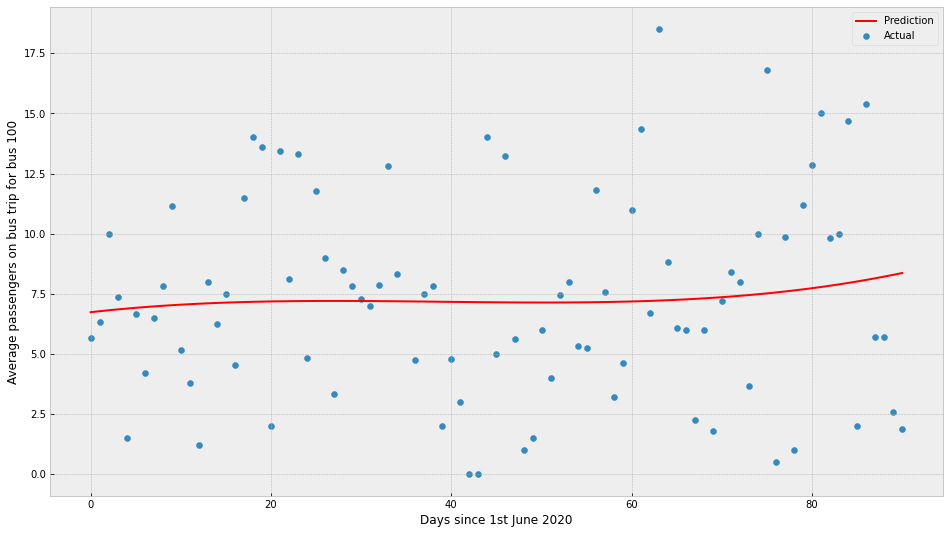

In [8]:
plt.style.use('bmh')
plt.figure(figsize=(16, 9))
plt.xlabel('Days since 1st June 2020')
plt.ylabel('Average passengers on bus trip for bus 100')
plt.scatter(x, y)
plt.plot(x, pol_reg.predict(x_poly), color='Red')
plt.legend(['Prediction', 'Actual'])
plt.show()

### Predictions on arbitrary date

In [9]:
# Functions that takes a date as a parameter and predicts number of passengers on the average bus trip that day
# Date in the format 'dd/mm/yyyy'
def predict(date) :
    day = days_since_genesis(date)
    return pol_reg.predict(poly_reg.fit_transform(([[day]])))[0]

To test the prediction lets pick three dates, one in the past, one in the dataset and one in the future

In [10]:
print(predict('17/05/2020'))
print(predict('14/08/2020'))
print(predict('24/12/2020'))

5.79057158509006
7.4797817829690025
55.32682528838502


We create a new dataframe containing the actual and predicted passengers on bus 100

### Error in prediction

In [11]:
score = pd.DataFrame({'Actual' : df['Passasjerer_Ombord'], 'Prediction' : pol_reg.predict(x_poly)})
score['PctDiff'] = (score['Prediction'] - score['Actual']) * 100 / score['Actual']

# We remove entries that are predicted but are not in the oringinal dataset
score = score[score.Actual != 0]

score

,Actual,Prediction,PctDiff
Day,,,
0,5.666667,6.732546,18.809641
1,6.333333,6.773700,6.953163
2,10.000000,6.812503,-31.874969
3,7.375000,6.849017,-7.131972
4,1.500000,6.883305,358.886989
...,...,...,...
86,15.400000,8.075917,-47.558979
87,5.714286,8.143363,42.508847
88,5.714286,8.213833,43.742085


The mean prediction percentage score would then be

In [12]:
score.mean(axis=0)[2]

68.28786264105108